# TUTORIAL 4: Style Flow
**Author** - [Vuong NGUYEN](https://github.com/XuanMinhVuongNGUYEN)

This tutorial introduces you to the basics of the [Augmentare](https://forge.deel.ai/Fair/augmentare) library to easily use the deployment of Machine Learning techniques to augment data in **PyTorch**. This tutorial mainly explores the core features of library, the predefined losses and the models. 

This tutorial assumes that your system has installed Pytorch and Augmentare properly.

This tutorial uses the highly popular StyleFlow For Content-Fixed Image to Image Translation or **Style Flow** architecture. **Augmentare** provides a generalised implementation of **STYLEFLOW**.

**Paper** - [StyleFlow For Content-Fixed Image to Image Translation by Weichen Fan & al.](https://arxiv.org/pdf/2207.01909.pdf)

In [1]:
try:
    import augmentare
    print(f"Existing Augmentare {augmentare.__version__} installation found")

except ImportError:
    import subprocess
    import sys

    subprocess.check_call([sys.executable, "-m", "pip", "install", "augmentare"])
    import augmentare

    print(f"Installed Augmentare {augmentare.__version__}")

/home/vuong.nguyen/vuong/augmentare/dev_augmentare/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Existing Augmentare 0.0.1 installation found


## IMPORTS

In [2]:
# General Imports
import matplotlib.pyplot as plt
import numpy as np
import random

# Pytorch and Torchvision Imports
import imageio.v3 as iio
from PIL import Image
import IPython.display as display
import cv2 as cv
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
import torchvision.transforms as transforms
from torchvision.transforms.functional import crop

# Augmentare Imports
import augmentare
from augmentare.methods.style_transfer import *
from augmentare.plots.plot_losses import plot_losses

In [3]:
#Cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## DATA LOADING AND PREPROCESSING
This tutorial uses the [**Laparoscopic Image to Image Translation**](http://opencas.dkfz.de/image2image/) dataset for illustration purposes.

Here the content image is the simulated image and the style image is the real image that we want to aim for.

We then wrap the dataset in a **DataLoader**. Because in the following sections, said **DataLoader** is required to be passed as a parameter while training.

In [4]:
def get_imgs_from_dir(path_a, path_b):
    file_a = open(path_a)
    list_a = []
    for lines in file_a.readlines():
        line = lines.strip('\n')
        list_a.append(line)
    file_a.close()

    file_b = open(path_b)
    list_b = []
    for lines in file_b.readlines():
        line = lines.strip('\n')
        list_b.append(line)
    file_b.close()
    return list_a,list_b

def get_mask(src):
    mask = np.zeros((src.size[1],src.size[0],3))

    mask[:,:,0] = mask[:,:,0] + np.random.randint(-20,20)
    mask[:,:,1] = mask[:,:,1] + np.random.randint(-20,20)
    mask[:,:,2] = mask[:,:,2] + np.random.randint(-20,20)
    return mask

def add_mask(img, mask):
    img_ = np.array(img)
    mask = cv.resize(mask, (img_.shape[1],img_.shape[0]), interpolation=cv.INTER_CUBIC)
    scr_arr = np.array(img_ + mask)#,dtype=np.uint8)


    scr_arr = np.clip(scr_arr,0,255)
    scr_arr = np.array(scr_arr,dtype=np.uint8)

    scr_arr = Image.fromarray(scr_arr)#.convert("RGB")
    return scr_arr

def default_loader(path):
    return Image.open(path)

In [5]:
class ImageFolder_pair(Dataset):
    def __init__(self, rootA, rootB, keep_percent=1, transform=None, transform2=None, return_paths=False,
                 loader= default_loader, dataset_num=1,get_direct=True,aug=True):
        imgsA=[]
        imgsB=[]
        imgsC=[]
        imgsD=[]
        codes=[]

        imgs_A_1,imgs_B_1 = get_imgs_from_dir(rootA,rootB)
        code_1 = [0]*len(imgs_A_1)

        #print('imgs_A_1: ',len(imgs_A_1))
        #print('imgs_B_1: ',len(imgs_B_1))
        imgsA += imgs_A_1
        imgsB += imgs_B_1

        random.shuffle(imgs_A_1)
        random.shuffle(imgs_B_1)
        imgsC += imgs_A_1
        imgsD += imgs_B_1

        codes += code_1
        codes += [-1]*len(codes)

        c = list(zip(imgsA, imgsB, codes))
        random.shuffle(c)
        imgsA, imgsB, codes = zip(*c)

        c = list(zip(imgsC, imgsD))
        random.shuffle(c)
        imgsC, imgsD = zip(*c)

        total_len = len(imgsA)
        self.rootA = rootA
        self.rootB = rootB
        self.imgsA = imgsA#[:int(keep_percent*total_len)+1]
        self.imgsB = imgsB#[:int(keep_percent*total_len)+1]
        self.imgsC = imgsC
        self.imgsD = imgsD
        self.code = codes#[:int(keep_percent*total_len)+1]
            
        self.transform = transform
        self.transform2 = transform2
        self.aug = aug
        self.return_paths = return_paths
        self.loader = loader

        print('len_imgA: ',len(self.imgsA))
        print('len_imgB: ',len(self.imgsB))
        #print('code: ',len(self.code))
    
    def __getitem__(self, index):
        #index = 0
        pathA = self.imgsA[index]
        pathB = self.imgsB[index]
        imgA = self.loader(pathA)
        imgB = self.loader(pathB)
        name = pathA.split('/')[-1]
        if self.aug:
            mask1 = get_mask(imgB)
        imgA_aug = add_mask(imgA,mask1)
        imgB_aug = add_mask(imgB,mask1)

        code = self.code[index]
        if self.transform is not None:
            if self.transform2 is not None:
                imgA = self.transform(imgA)
                imgB = self.transform2(imgB)
            else:
                imgA = self.transform(imgA)
                imgB = self.transform(imgB)
            imgA_aug = self.transform(imgA_aug)
            imgB_aug = self.transform(imgB_aug)
            code = torch.tensor([code],dtype=torch.float32)
        if self.return_paths:
            return imgA, imgB
        else:
            return imgA, imgB, imgA, imgB, code, imgA_aug, imgB_aug, imgA_aug, imgB_aug

    def __len__(self):
        return len(self.imgsA)

In [6]:
def crop_real_img(image):
    return crop(image, 25, 170, 490, 620)

def crop_vr_img(image):
    return crop(image, 25, 170, 680, 945)

def get_data_loader_folder_pair(input_folderA, input_folderB, batch_size, train, keep_percent, new_size=None,
                           height=256, width=256, num_workers=8, crop=True,get_direct=True,train_vr=False,return_paths=False):
    if train_vr is False:
        transform_list = []
        transform_list.append(transforms.Resize((300,400)))
        transform_list.append(transforms.ToTensor())
        transform = transforms.Compose(transform_list)
        transform2=None
    else:
        transform_list = []
        transform_list.append(torchvision.transforms.Lambda(lambda img: crop_vr_img(img)))
        transform_list.append(transforms.Resize((300,400)))
        transform_list.append(transforms.ToTensor())
        transform = transforms.Compose(transform_list)

        transform_list2 = []
        transform_list2.append(torchvision.transforms.Lambda(lambda img: crop_real_img(img)))
        transform_list2.append(transforms.Resize((300,400)))
        transform_list2.append(transforms.ToTensor())
        transform2 = transforms.Compose(transform_list2)

    dataset = ImageFolder_pair(input_folderA, input_folderB, keep_percent=keep_percent, transform=transform,transform2=transform2,get_direct=get_direct,return_paths=return_paths)
    return dataset

In [7]:
class DistributedGivenIterationSampler(Sampler):
    def __init__(self, dataset, total_iter, batch_size, world_size=None, rank=None, last_iter=-1):
        self.dataset = dataset
        self.total_iter = total_iter
        self.batch_size = batch_size
        self.world_size = world_size
        self.rank = rank
        self.last_iter = last_iter

        self.total_size = self.total_iter*self.batch_size

        self.indices = self.gen_new_list()
        self.call = 0

    def __iter__(self):
        if self.call == 0:
            self.call = 1
            return iter(self.indices[(self.last_iter+1)*self.batch_size:])
        else:
            raise RuntimeError("this sampler is not designed to be called more than once!!")

    def gen_new_list(self):

        # each process shuffle all list with same seed, and pick one piece according to rank
        np.random.seed(0)

        all_size = self.total_size * self.world_size
        indices = np.arange(len(self.dataset))
        indices = indices[:all_size]
        num_repeat = (all_size-1) // indices.shape[0] + 1
        indices = np.tile(indices, num_repeat)
        indices = indices[:all_size]

        np.random.shuffle(indices)
        beg = self.total_size * self.rank
        indices = indices[beg:beg+self.total_size]
        #print('len: ',len(indices))
        #print('total: ',self.total_size)
        assert len(indices) == self.total_size

        return indices

    def __len__(self):
        # note here we do not take last iter into consideration, since __len__
        # should only be used for displaying, the correct remaining size is
        # handled by dataloader
        #return self.total_size - (self.last_iter+1)*self.batch_size
        return self.total_size

#### Get source and target txt file

We will create txt files containing the paths of all the images in the directory that we want to load to train the model. Please skip this step if we already created these txt files.

In [ ]:
# outputfile	= "/home/vuong.nguyen/vuong/augmentare/tutorials/methods/style_transfer/src_sim.txt"
# folder		= "/home/vuong.nguyen/vuong/augmentare/Datasets/SimReal/sim"

# with open(outputfile, "w") as txtfile:
# 	for path in os.listdir(folder):
# 		full_path = os.path.join(folder, path)
# 		if os.path.isfile(full_path):
# 			print(full_path)
# 			txtfile.write("%s\n" % full_path)
# txtfile.close()

In [8]:
source_path = '/home/vuong.nguyen/vuong/augmentare/tutorials/methods/style_transfer/src_sim.txt'
target_path = '/home/vuong.nguyen/vuong/augmentare/tutorials/methods/style_transfer/trg_real.txt'

In [9]:
train_dataset = get_data_loader_folder_pair(source_path,
                                            target_path,
                                            1, 
                                            True, 
                                            1,
                                            get_direct=False,
                                            train_vr=False,
                                            return_paths = True)

len_imgA:  485
len_imgB:  485


In [10]:
train_sampler = DistributedGivenIterationSampler(train_dataset,
        25000, 1, world_size=1, rank=0, last_iter=-1)

In [11]:
train_loader = DataLoader(
        train_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=4,
        pin_memory=False,
        sampler=train_sampler)

#### Show the content image

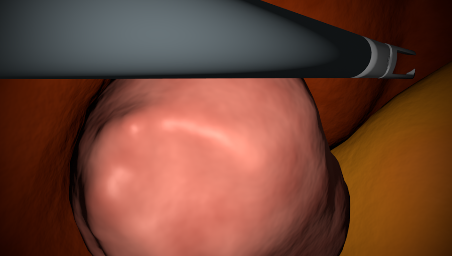

In [4]:
content_path = '/home/vuong.nguyen/vuong/augmentare/Datasets/SimReal/sim/img00003.png'
content_image = Image.open(content_path)
display.display(content_image)

#### Show the style image

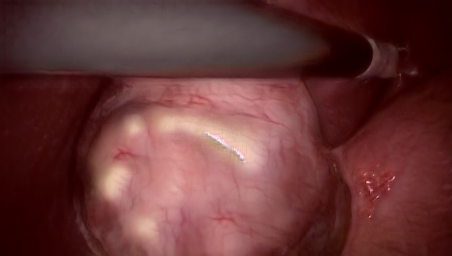

In [5]:
style_path = '/home/vuong.nguyen/vuong/augmentare/Datasets/SimReal/real/img00003.png'
style_image = Image.open(style_path)
display.display(style_image)

In [14]:
content_image = content_image.resize((512,256), Image.Resampling.BICUBIC)
style_image = style_image.resize((512,256), Image.Resampling.BICUBIC)

In [15]:
content_image = np.asarray(content_image, np.float32)
style_image = np.asarray(style_image, np.float32)

In [16]:
content_image = content_image.transpose((2, 0, 1))
style_image = style_image.transpose((2, 0, 1))

content_image = np.expand_dims(content_image, axis=0)
style_image = np.expand_dims(style_image, axis=0)

In [17]:
content_image = torch.from_numpy(content_image)
style_image = torch.from_numpy(style_image)

## NETWORK ARCHITECTURE : Style Flow

With the invertible network structure, StyleFlow first projects the input images into the feature space in the forward, while the backward uses the SAN module to perform the fixed feature transformation of the content, and then projects them into image space.

<img src="/home/vuong.nguyen/vuong/augmentare/tutorials/imgs/flow.png" width=800 alt="Picture" style="display: block; margin: 0 auto" />


The blue arrows indicate the forward pass to extract the features, while the red arrows represent the backward pass to reconstruct the images. StyleFlow consists of a series of reversible blocks, where each block has three components: the `Squeeze module`, the `Flow module`, and the `SAN module`. A pre-trained VGG encoder is used for domain feature extraction.
    <ul> <li> <span style="color:gold"> Squeeze module: </span> <span> The Squeeze operation serves as an interconnection between blocks for reordering features. It reduces the spatial size of the feature map by first dividing the input feature into small patches along the spatial dimension and then concatenating the patches along the channel dimension. </span> </li>
    <li> <span style="color:gold"> Flow module: </span> <span> The Flow module consists of three reversible transformations: Actnorm Layer, 1x1 Convolution Layer, and Coupling Layer. </span> </li>
    <li> <span style="color:gold"> SAN module: </span> <span> SAN module to perform fixed content feature transformation. Fixed content transfer means that content information before and after transformation should be retained. </span> </li> </ul>

**StyleFlow**

Hyperparameters:

`in_channel:` Number of channel

`n_flow:` Number of Flow

`n_block:` Number of Block

`vgg_path:` Path of vgg_normalised

`affine:` If true use AffineCoupling

`conv_lu:` If true use InvConv2dLU otherwise use InvConv2d

`keep_ratio:` Keep ratio for Net

`device:` CPU or CUDA

In [18]:
vgg_path = '/home/vuong.nguyen/vuong/augmentare/augmentare/methods/style_transfer/model/vgg_normalised_flow.pth'
model = STYLEFLOW(in_channel=3, n_flow=15, n_block=2, vgg_path=vgg_path,
                            affine=False, conv_lu=False, keep_ratio=0.8, device=device)

## TRAINING THE STYLEFLOW NETWORK

Train the StyleFlow network and return the losses.

Parameters:

`train_loader:` Torch.tensor or Dataloader (Pairs of content images and style images)

`content_weight:` Weight of content

`style_weight:` Weight of style

`type_loss:` Type of loss function that you want to use

Returns:

`loss_train:` The losses of training process StyleFlow

In [19]:
loss_train = model.train_network(train_loader=train_loader,
            content_weight = 0.1, style_weight=1, type_loss="TVLoss"
        )

[0/25000 Stylizations], 	Loss: 1.9331603050231934
[500/25000 Stylizations], 	Loss: 0.4342310428619385
[1000/25000 Stylizations], 	Loss: 0.40727826952934265
[1500/25000 Stylizations], 	Loss: 0.2055433690547943
[2000/25000 Stylizations], 	Loss: 0.2938874065876007
[2500/25000 Stylizations], 	Loss: 0.35302647948265076
[3000/25000 Stylizations], 	Loss: 0.2233668863773346
[3500/25000 Stylizations], 	Loss: 0.33728307485580444
[4000/25000 Stylizations], 	Loss: 0.27868062257766724
[4500/25000 Stylizations], 	Loss: 0.2589837312698364
[5000/25000 Stylizations], 	Loss: 0.11013823002576828
[5500/25000 Stylizations], 	Loss: 0.21043263375759125
[6000/25000 Stylizations], 	Loss: 0.1985003799200058
[6500/25000 Stylizations], 	Loss: 0.12254144996404648
[7000/25000 Stylizations], 	Loss: 0.22935856878757477
[7500/25000 Stylizations], 	Loss: 0.27831798791885376
[8000/25000 Stylizations], 	Loss: 0.25664666295051575
[8500/25000 Stylizations], 	Loss: 0.162260502576828
[9000/25000 Stylizations], 	Loss: 0.23478

#### Plots the Losses

Plots losses for StyleFlow on a common plot.

Parameters:

`losses:` A list of losses that you want to plot

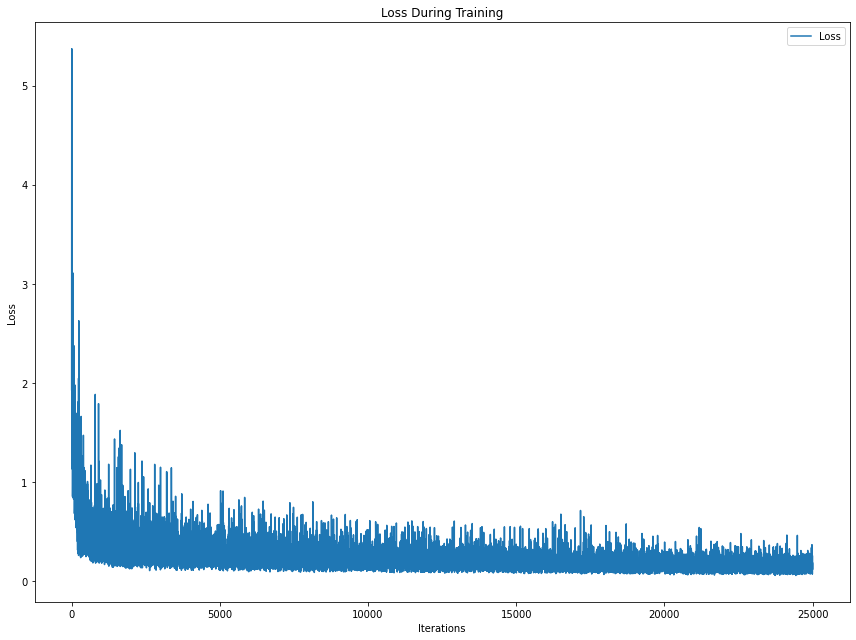

In [20]:
plot_losses(loss_train)

## VISUALIZE THE GENERATED DATA

**Styled images from the StyleFlow**

A function that generates styled image after training by StyleFlow method.

Parameters:

`content_image:` Content image that we choose to stylizer

`style_image:` Style image that we choose for style transfer

Returns:

`gen_image:` Generated image

In [21]:
gen_image = model.style_flow_generate(
    content_image= content_image,
    style_image= style_image
)

In [22]:
torch.cuda.empty_cache()

In [23]:
new_im_out = np.clip(gen_image[0].permute(1, 2, 0).detach().cpu().numpy(), 0., 1.)
new_im_out = (new_im_out * 255).astype(np.uint8)

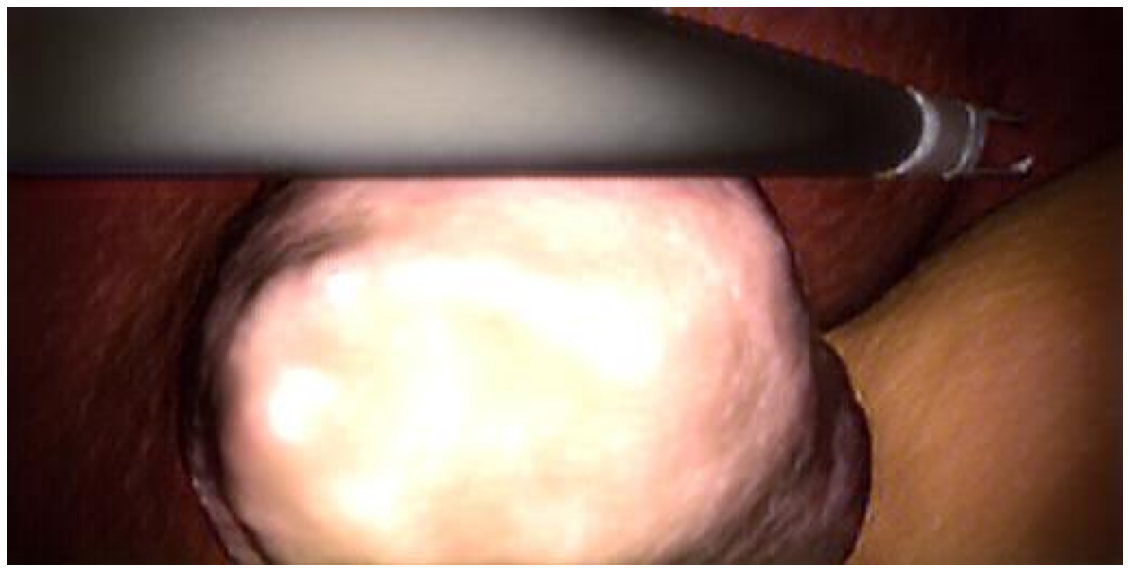

In [12]:
plt.figure(figsize=(20,25))
plt.imshow(new_im_out)
plt.axis('off')
plt.show()

In [25]:
iio.imwrite(f'/home/vuong.nguyen/vuong/augmentare/tutorials/methods/style_transfer/output/flow/gen_image_styleflow_2.jpg', new_im_out)

#### Plot generated image

In [11]:
output = Image.open(f'/home/vuong.nguyen/vuong/augmentare/tutorials/methods/style_transfer/output/flow/gen_image_styleflow_2.jpg')

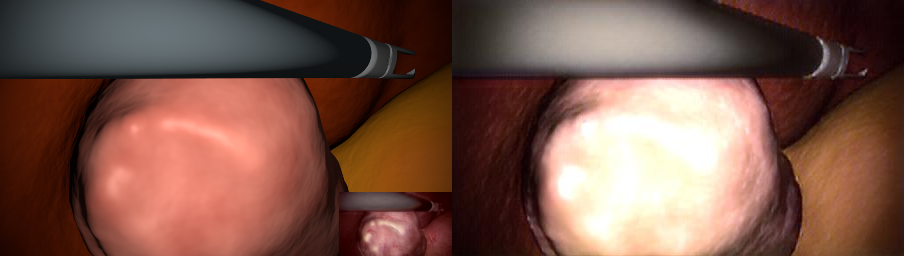

In [9]:
content_image = Image.open(content_path)
style_image = Image.open(style_path)

demo = Image.new('RGB', (content_image.width * 2, content_image.height))
output = output.resize(content_image.size)
style_image = style_image.resize((i // 4 for i in content_image.size))

demo.paste(content_image, (0, 0))
demo.paste(output, (content_image.width, 0))
demo.paste(style_image, (content_image.width - style_image.width, content_image.height - style_image.height))

display.display(demo)

In [28]:
demo.save(f"/home/vuong.nguyen/vuong/augmentare/tutorials/methods/style_transfer/output/flow/output2.png")

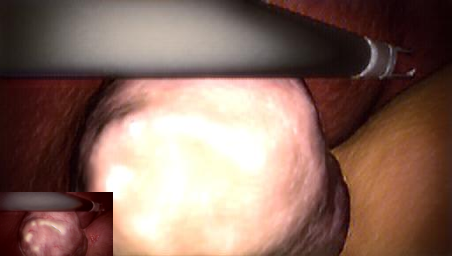

In [10]:
output.paste(style_image, (0, output.height - style_image.height))
display.display(output)